In [68]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
from shapely import wkt
import matplotlib.pyplot as plt
import numpy as np
import fiona 
from geopy import Nominatim #unused but wow!
import cartopy.crs as ccrs #unused
#import geoplot

Data Visualisation sheet (by Stefanie)

In [64]:
# Reading in the joint data table and converting it into a geodataframe
df_jointdata = pd.read_csv(r'cleaning_data\joint_data.csv')
df_jointdata.drop('Unnamed: 0', axis=1, inplace=True)
df_jointdata.head()

,route_id,route_linestring,num_of_waypoint,waypoint_longitude,waypoint_latitude,poi_lat_lgt,poi_longitude,poi_latitude,poi_category,poi_name,distance
0,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",133,13.67734,52.43849,POINT (13.6774745 52.4385208),13.677475,52.438521,['viewpoint'],Müggeleck,0.000138
1,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",282,13.62759,52.44386,POINT (13.6279051 52.444312),13.627905,52.444312,['bench'],NaN,0.000551
2,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",288,13.62704,52.44442,POINT (13.6271595 52.4444457),13.627159,52.444446,['bench'],NaN,0.000122
3,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",288,13.62704,52.44442,POINT (13.6269487 52.4444808),13.626949,52.444481,['bench'],NaN,0.000110
4,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",292,13.62716,52.44509,POINT (13.6273851 52.4453161),13.627385,52.445316,['bench'],NaN,0.000319


In [65]:
# Converting Linestring object to geometry again
df_jointdata['route_linestring'] = gpd.GeoSeries.from_wkt(df_jointdata['route_linestring'])
gdf_jointdata = gpd.GeoDataFrame(df_jointdata, geometry='route_linestring')
gdf_jointdata.set_crs('epsg:3857', inplace=True)
gdf_jointdata.head()

,route_id,route_linestring,num_of_waypoint,waypoint_longitude,waypoint_latitude,poi_lat_lgt,poi_longitude,poi_latitude,poi_category,poi_name,distance
0,113043,"LINESTRING (13.691 52.451, 13.691 52.451, 13.6...",133,13.67734,52.43849,POINT (13.6774745 52.4385208),13.677475,52.438521,['viewpoint'],Müggeleck,0.000138
1,113043,"LINESTRING (13.691 52.451, 13.691 52.451, 13.6...",282,13.62759,52.44386,POINT (13.6279051 52.444312),13.627905,52.444312,['bench'],NaN,0.000551
2,113043,"LINESTRING (13.691 52.451, 13.691 52.451, 13.6...",288,13.62704,52.44442,POINT (13.6271595 52.4444457),13.627159,52.444446,['bench'],NaN,0.000122
3,113043,"LINESTRING (13.691 52.451, 13.691 52.451, 13.6...",288,13.62704,52.44442,POINT (13.6269487 52.4444808),13.626949,52.444481,['bench'],NaN,0.000110
4,113043,"LINESTRING (13.691 52.451, 13.691 52.451, 13.6...",292,13.62716,52.44509,POINT (13.6273851 52.4453161),13.627385,52.445316,['bench'],NaN,0.000319


In [70]:
# Creating a child gdf, that would only contain each occuring linestring once
gdf_routesunique = gdf_jointdata.drop_duplicates(subset = ['route_linestring'])

In [66]:
# Reading in a map of post codes in Germany and a csv with post codes corresponding cities and filtering for Berlin
plz_shape_df = gpd.read_file(r'data_visualisation\plz-5stellig.shp', dtype={'plz': str})
plz_region_df = pd.read_csv(r'data_visualisation\zuordnung_plz_ort.csv', sep=',', dtype={'plz': str})
germany_df = pd.merge(left=plz_shape_df, right=plz_region_df, on='plz', how='inner')
berlin_df = germany_df.query('ort == "Berlin"')
gdf_berlin = gpd.GeoDataFrame(berlin_df)
gdf_berlin.to_crs('epsg:3857', inplace=True)

In [67]:
gdf_berlin.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [73]:
gdf_routesunique.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

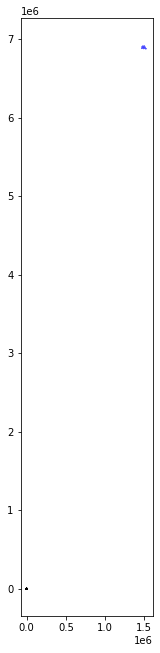

In [82]:
# 1 Printing routes on map of Berlin #not working yet
fig, ax = plt.subplots() #sharex=True
gdf_routesunique.plot(ax=ax, color='black', alpha=1)
gdf_berlin.plot(ax=ax, color='blue')

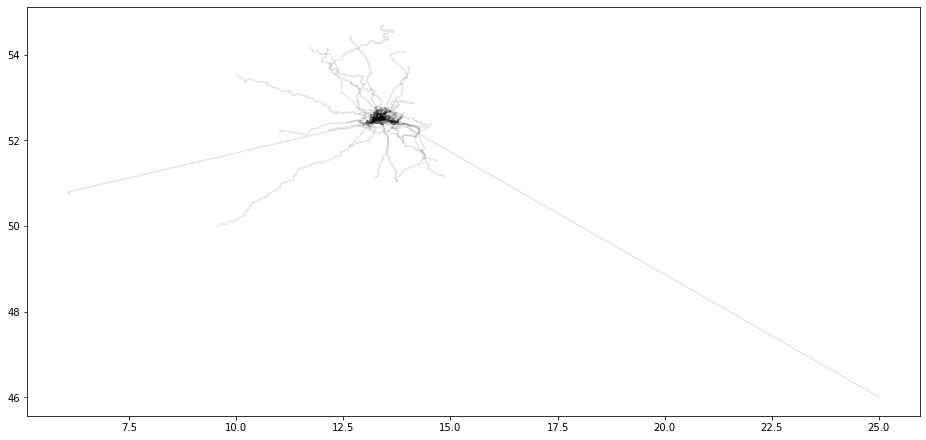

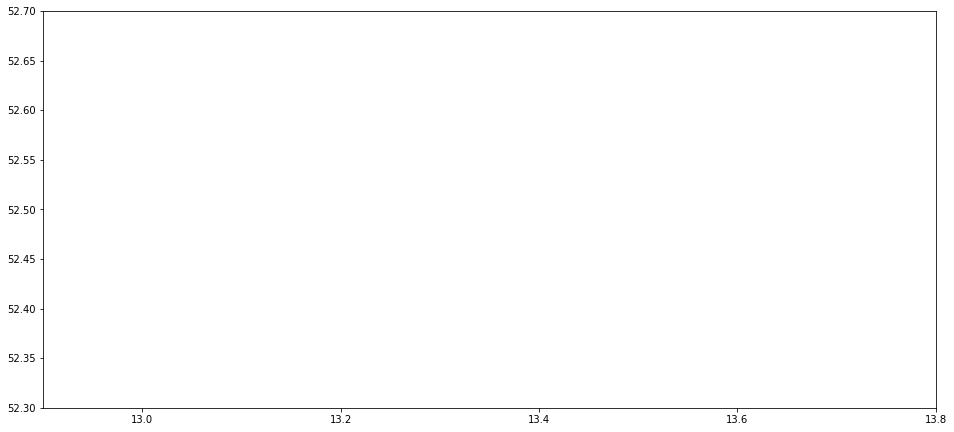

In [80]:
# 2 Printing routes on map of Berlin #not working yet
city_long_border = (12.9, 13.8)
city_lat_border = (52.3, 52.7)
ax1 = gdf_routesunique.plot(color='black', alpha=0.1)
ax2 = gdf_berlin.plot(color='blue', alpha=0.1)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

C:\Users\ina.schulz\AppData\Local\Programs\Python\Python310\lib\site-packages\contextily\tile.py:581: UserWarning: The inferred zoom level of 24 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


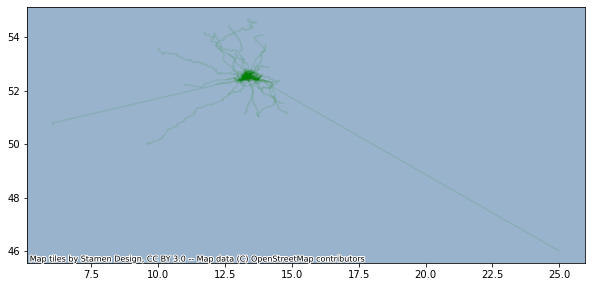

In [75]:
# 3 Printing routes on map of Berlin #not working yet
import contextily as cx
gdf_routesunique = gdf_routesunique.to_crs(epsg=3857)
ax = gdf_routesunique.plot(figsize=(10, 10), alpha=0.1, color='green')
cx.add_basemap(ax, crs=gdf_routesunique.crs.to_string())

62.0

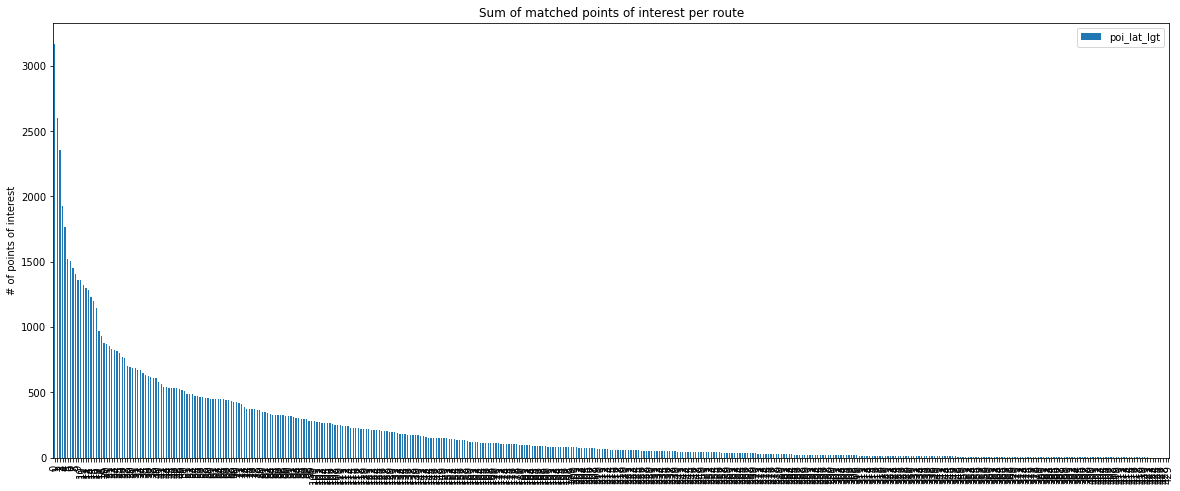

In [39]:
# Summarising the matching points of interest per each route
gdf_poiperroute = gdf_jointdata.groupby(by='route_id').agg({'poi_lat_lgt':'count'}).reset_index().sort_values(by='poi_lat_lgt', ascending=False)
barplot = gdf_poiperroute.plot.bar(x='route_id', xlabel = 'routes', ylabel = '# of points of interest', title='Sum of matched points of interest per route', use_index=False, figsize=(20,8))
gdf_poiperroute['poi_lat_lgt'].median()
# Better to make it with matplotlib ...